In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/MapsDataCities.zip'

In [ ]:
import os
from PIL import Image
f = r'/content/drive/MyDrive/MapsDataCities'
#f_open = r'/content/drive/MyDrive/maps_data/patterns'
#f_save = r'/content/drive/MyDrive/maps_data'
#img_number = 0

for file in os.listdir(f):
  #print(file)
  try:
    #print(re.search(r'\d+', file).group(0))
    #print(file)
    f_img = f +"/" + file
    #f_number = f + "/" + re.search(r'\d+', file).group(0)
    #os.rename(f_img, str(f_number))
    image = Image.open(f_img)
  except:
    print("//")
    print("filename no number")
    print(file)
    print("//")
  #img_number += 1
  #f_img = f_open+"/"+file
  #f_img_save = f_save + "/" + file
  #image = Image.open(f_img)
  #print(image.size)
#  try:
#    f_img = f+"/"+file
#    image = Image.open(f_img)
#    image = image.resize((301,301),Image.ANTIALIAS)
#    image.save(f_img_save,quality=95)
#    os.rename(f_img_save, str(f_img_save))
#  except:
#    print("exception, shame")

In [2]:
import pathlib
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
import tensorflow as tf

In [3]:
kernel_size = 4
stride = 2
padding = 4
dilation= 2
init_kernel = 8 # initial number of filters

In [4]:
import os

PROJECT_PATH = os.path.dirname(os.path.dirname(os.path.realpath('__file__')))
print(PROJECT_PATH)
#DATAPATH = os.path.join(PROJECT_PATH,'content/drive/MyDrive','maps_data')
DATAPATH = os.path.join(PROJECT_PATH,'content/drive/MyDrive','MapsDataCities')
print(DATAPATH)

/
/content/drive/MyDrive/MapsDataCities


In [5]:
data_root = pathlib.Path(DATAPATH)
print(data_root)

/content/drive/MyDrive/MapsDataCities


In [6]:
import sys
import os
import tensorflow as tf
import random


def preprocess_image(image):
    image = tf.io.decode_png(image, channels=3)
    image = tf.image.resize(image, [286, 286])
    image /= 255.0  # normalize to [0,1] range

    return image


def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)


def get_filepaths(dirpath):
    """
    Return paths of all files in a directory.
    :param dirpath:
    :return:
    """
    data_root = pathlib.Path(dirpath)
    all_image_paths = list(data_root.glob('*'))
    all_image_paths = [str(path) for path in all_image_paths]
    random.shuffle(all_image_paths)

    return all_image_paths


def load_dataset(dirpath):

    all_image_paths = get_filepaths(dirpath)
    path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)
    image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    return image_ds

In [7]:
ds = load_dataset(data_root)

In [8]:
import numpy as np
import torchvision

In [9]:
# define a Conv VAE
class ConvVAE(nn.Module):
    def __init__(self):
        super(ConvVAE, self).__init__()
 
        # encoder
        self.enc1 = nn.Conv2d(
            in_channels=3, out_channels=init_kernel, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )
        self.enc2 = nn.Conv2d(
            in_channels=init_kernel, out_channels=init_kernel*2, kernel_size=kernel_size, 
            stride=stride#, padding=padding
        )
        self.enc3 = nn.Conv2d(
            in_channels=init_kernel*2, out_channels=init_kernel*4, kernel_size=kernel_size, 
            stride=stride#, padding=padding, dilation=dilation
        )
        self.enc4 = nn.Conv2d(
            in_channels=init_kernel*4, out_channels=init_kernel*8, kernel_size=kernel_size, 
            stride=stride#, padding=padding
        )
        self.enc5 = nn.Conv2d(
            in_channels=init_kernel*8, out_channels=init_kernel, kernel_size=kernel_size, 
            stride=stride#, padding=padding
        )
        # decoder 
        self.dec1 = nn.ConvTranspose2d(
            in_channels=init_kernel, out_channels=init_kernel*8, kernel_size=kernel_size, 
            stride=stride#, padding=padding, dilation=dilation
        )
        self.dec2 = nn.ConvTranspose2d(
            in_channels=init_kernel*8, out_channels=init_kernel*4, kernel_size=kernel_size, 
            stride=stride#, padding=padding, dilation=dilation
        )
        self.dec3 = nn.ConvTranspose2d(
            in_channels=init_kernel*4, out_channels=init_kernel*2, kernel_size=kernel_size, 
            stride=stride#, padding=padding, dilation=dilation
        )
        self.dec4 = nn.ConvTranspose2d(
            in_channels=init_kernel*2, out_channels=init_kernel, kernel_size=kernel_size, 
            stride=stride#, padding=padding, dilation=dilation
        )
        self.dec5 = nn.ConvTranspose2d(
            in_channels=init_kernel, out_channels=3, kernel_size=kernel_size, 
            stride=stride#, padding=padding, dilation=dilation
        )
        
    def encode(self, x):
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        x = self.enc5(x)
        mu = x
        log_var = x

        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)
        return z, mu, log_var
    
    def decode(self, z):
        x = F.relu(self.dec1(z))
        #print(x.shape)
        x = F.relu(self.dec2(x))
        #print(x.shape)
        x = F.relu(self.dec3(x))
        #print(x.shape)
        x = F.relu(self.dec4(x))
        #print(x.shape)
        return torch.sigmoid(self.dec5(x))

    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling
        return sample
 
    def forward(self, x):
        # encoding
        x = F.relu(self.enc1(x))
        #print("enc1: " + str(x.size()))
        x = F.relu(self.enc2(x))
        #print("enc2: " + str(x.size()))
        x = F.relu(self.enc3(x))
        #print("enc3: " + str(x.size()))
        x = F.relu(self.enc4(x))
        #print("enc4: " + str(x.size()))
        x = self.enc5(x)
        #print("enc5: " + str(x.size()))
        # get `mu` and `log_var`
        mu = x
        log_var = x
        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)
        #print(z.shape)
 
        # decoding
        x = F.relu(self.dec1(z))
        #print("dec1: " + str(x.size()))
        #print("In channels: " + str(init_kernel))
        #print("Out channels: " + str(init_kernel*8))
        #print("Kernel Size:  constant at 10")
        x = F.relu(self.dec2(x))
        #print("dec2: " + str(x.size()))
        #print("In channels: " + str(init_kernel*8))
        #print("Out channels: " + str(init_kernel*4))
        #print("Kernel Size:  constant at 10")
        x = F.relu(self.dec3(x))
        #print("dec3: " + str(x.size()))
        #print("In channels: " + str(init_kernel*4))
        #print("Out channels: " + str(init_kernel*2))
        #print("Kernel Size:  constant at 10")
        x = F.relu(self.dec4(x))
        #print("dec4: " + str(x.size()))
        #print("In channels: " + str(init_kernel*2))
        #print("Out channels: " + str(init_kernel))
        #print("Kernel Size:  constant at 10")
        reconstruction = torch.sigmoid(self.dec5(x))
        #print("reconstruction: " + str(reconstruction.size()))
        #print("In channels: " + str(init_kernel))
        #print("Out channels: " + str(3))
        #print("Kernel Size:  constant at 10")
        return reconstruction, mu, log_var, z

In [10]:
import scipy.io
import torch
import torch.optim as optim
import torch.nn as nn
#import model
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from torchvision.utils import save_image

In [11]:
# learning parameters
batch_size = 1
#lr = 0.001
lr = 0.002
epochs = 800
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
from torch.utils import data
import sys

#sys.path.append('../')
from torchvision import datasets
# from skimage import io, transform
import os
import re

from PIL import Image

import torch
from PIL import Image, ImageOps
import numpy as np

import torchvision
import torchvision.transforms.functional as trF


class Invert(object):
    """Inverts the color channels of an PIL Image
    while leaving intact the alpha channel.
    """

    def invert(self, img):
        r"""Invert the input PIL Image.
        Args:
            img (PIL Image): Image to be inverted.
        Returns:
            PIL Image: Inverted image.
        """
        #if not trF._is_pil_image(img):
        #    raise TypeError('img should be PIL Image. Got {}'.format(type(img)))

        if img.mode == 'RGBA':
            r, g, b, a = img.split()
            inv = Image.merge('RGB', (r, g, b))
            #inv = ImageOps.invert(rgb)
            #r, g, b = inv.split()
            #inv = Image.merge('RGBA', (r, g, b, a))
        elif img.mode == 'LA':
            l, a = img.split()
            l = ImageOps.invert(l)
            inv = Image.merge('LA', (l, a))
        else:
            inv = ImageOps.invert(img)
        return inv

    def __call__(self, img):
        """
        Args:
            img (PIL Image): Image to be inverted.
        Returns:
            PIL Image: Inverted image.
        """
        return self.invert(img)

    def __repr__(self):
        return self.__class__.__name__ + '()'

class CityImageDataset(data.Dataset):
    """
    Urban images dataset.
    """

    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.image_files = [f for f in os.listdir(root) if not f.startswith('.')]
        #self.image_names = [''.join(re.findall(r'[^\/]+(?=\.)',f)) for f in os.listdir(root) if not f.startswith('.')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root,self.image_files[idx])
        sample = Image.open(img_name)

        if self.transform:
            sample = self.transform(sample)

        return sample

    def __getname__(self, idx):
        return self.image_files[idx]

In [13]:
to_pil_image = transforms.ToPILImage()

city_dataset = CityImageDataset(root=data_root,transform=torchvision.transforms.Compose([    
    #torchvision.transforms.Grayscale(num_output_channels=3),                                                                                 
    Invert(),
    torchvision.transforms.RandomCrop(286),
    torchvision.transforms.ToTensor(),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]))

In [16]:
validation_split = .0
shuffle_dataset = True
random_seed= 42
dataset_size = len(city_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

In [17]:
print(len(train_indices))
print(len(val_indices))
print(dataset_size)

15062
0
15062


In [18]:
from torch.utils.data.sampler import SubsetRandomSampler

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(city_dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(city_dataset, batch_size=batch_size,
                                                sampler=valid_sampler)

In [ ]:
#print(''.join(re.findall(r'[^\/]+(?=\.)',train_loader.dataset.__getname__(2))))
print(train_loader.dataset.__getname__(2))

19734.png


In [ ]:
#Pytorch Autoencoder
from torchvision.utils import save_image
from torchvision.utils import make_grid
import imageio
def get_device():
    if torch.cuda.is_available():
        print("gpu")
        device = 'cuda:0'
    else:
        print("cpu")
        device = 'cpu'
    return device
def make_dir():
    image_dir = 'CityDatasetMap_Images'
    if not os.path.exists(image_dir):
        os.makedirs(image_dir)
def save_decoded_image(img, name):
    img = img.view(img.size(0), 3, 286, 286)
    save_image(img, name)
def make_dir():
    image_dir = 'CityDatasetMap_Images'
    if not os.path.exists(image_dir):
        os.makedirs(image_dir)
def image_to_vid(images):
    imgs = [np.array(to_pil_image(img)) for img in images]
    imageio.mimsave('./CityDatasetMap_Images/generated_images.gif', imgs)
def save_reconstructed_images(recon_images, epoch):
    save_image(recon_images.cpu(), f"./CityDatasetMap_Images/output{epoch}.jpg")
def save_loss_plot(train_loss, valid_loss):
    plt.figure(figsize=(10, 7))
    plt.plot(train_loss, color='orange', label='train loss')
    plt.plot(valid_loss, color='red', label='validataion loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('./CityDatasetMap_Images/loss_graph.jpg')
    plt.show()

In [ ]:
model = ConvVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss(reduction='sum')

In [ ]:
def final_loss(bce_loss, mu, logvar, beta):
    """
    This function will add the reconstruction loss (BCELoss) and the 
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param bce_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    BCE = bce_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + 1 + beta * KLD

In [ ]:
def fit(model, dataloader, beta):
    model.train()
    running_loss = 0.0
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_indices)/dataloader.batch_size)):
        #print("data " + str(i))
        #print(dataloader.dataset.__getname__(i))
        data = data
        data = data.to(device)
        data = data
        optimizer.zero_grad()
        reconstruction, mu, logvar, z = model(data)
        #print(reconstruction.size())
        #print(data.size())
        bce_loss = criterion(reconstruction, data)
        loss = final_loss(bce_loss, mu, logvar, beta)
        loss.backward()
        running_loss += loss.item()
        optimizer.step()
    train_loss = running_loss/len(dataloader.dataset)
    return train_loss

In [ ]:
def validate(model, dataloader, beta):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_indices)/dataloader.batch_size)):
            data = data
            data = data.to(device)
            data = data
            reconstruction, mu, logvar, z = model(data)
            bce_loss = criterion(reconstruction, data)
            loss = final_loss(bce_loss, mu, logvar, beta)
            running_loss += loss.item()
        
            # save the last batch input and output of every epoch
            if i == int(len(val_indices)/dataloader.batch_size) - 1:
                num_rows = 8
                both = torch.cat((data[:8], reconstruction[:8]))
                recon_images = reconstruction
                #save_image(both.cpu(), f"../outputs/output{epoch}.png", nrow=num_rows)
                #save_decoded_image(both.cpu().data, name='./CityDatasetMap_Images/decoded{}.png'.format(epoch))
    val_loss = running_loss/len(dataloader.dataset)
    return val_loss, recon_images

In [ ]:
train_loss = []
val_loss = []
grid_images = []
make_dir() 
beta = 6
min_beta = 1
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    #print(train_loader)
    train_epoch_loss = fit(model, train_loader, beta)
    val_epoch_loss, recon_images = validate(model, validation_loader, beta)
    beta *= 0.998
    if beta < min_beta: 
        beta = min_beta
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {val_epoch_loss:.4f}")
    # save the reconstructed images from the validation loop
    save_reconstructed_images(recon_images, epoch+1)
    # convert the reconstructed images to PyTorch image grid format
    image_grid = make_grid(recon_images.detach().cpu())
    grid_images.append(image_grid)

# save the reconstructions as a .gif file
image_to_vid(grid_images)
# save the loss plots to disk
save_loss_plot(train_loss, val_loss)
print('TRAINING COMPLETE')

**VISUALISATION AND ANALYSIS**


In [19]:
#setup
import sklearn
import scipy
import numba
!pip install umap-learn

     |████████████████████████████████| 81kB 5.4MB/s 
     |████████████████████████████████| 1.2MB 10.4MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-cp37-none-any.whl size=76569 sha256=4d150d2fb0a2cedcf29cefdb79657d0cd74959cc32a6c99d3b480eddabbc7bd0
  Stored in directory: /root/.cache/pip/wheels/ad/df/d5/a3691296ff779f25cd1cf415a3af954b987fb53111e3392cf4
  Created wheel for pynndescent: filename=pynndescent-0.5.2-cp37-none-any.whl size=51351 sha256=54b009ed27b45fa99be47df963190854073345b2c97fe2f86a5458d987d36963
  Stored in directory: /root/.cache/pip/wheels/ba/52/4e/4c28d04d144a28f89e2575fb63628df6e6d49b56c5ddd0c74e
Successfully built umap-learn pynndescent


In [20]:
MODEL_PATH = os.path.join(PROJECT_PATH,'content/drive/MyDrive/TrainedModels','ModelBeta_600e_15k_lr003')

In [ ]:
#torch.save(model.state_dict(), MODEL_PATH)

In [21]:
model_loaded = ConvVAE().to(device)
model_loaded.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

In [22]:
test_device = "cpu"
model_loaded.to(test_device)

ConvVAE(
  (enc1): Conv2d(3, 8, kernel_size=(4, 4), stride=(2, 2), padding=(4, 4))
  (enc2): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2))
  (enc3): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2))
  (enc4): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
  (enc5): Conv2d(64, 8, kernel_size=(4, 4), stride=(2, 2))
  (dec1): ConvTranspose2d(8, 64, kernel_size=(4, 4), stride=(2, 2))
  (dec2): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2))
  (dec3): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2))
  (dec4): ConvTranspose2d(16, 8, kernel_size=(4, 4), stride=(2, 2))
  (dec5): ConvTranspose2d(8, 3, kernel_size=(4, 4), stride=(2, 2))
)

In [23]:
import numpy as np
z_images = np.zeros((15062,392))
image_names = []
image_tensors = []
print(type(z_images))
with torch.no_grad():
    for idx, image in tqdm(enumerate(train_loader), total=int(len(train_indices)/train_loader.batch_size)):
        #print(image.shape)
        #z_image = model_loaded.encode(image)[0]#.numpy()
        z_image = model_loaded.encode(image)[0]
        image_name = train_loader.dataset.__getname__(idx)
        #print(torch.flatten(z_image, start_dim=1).shape)
        #print(z_image)
        z_images[idx] = torch.flatten(z_image, start_dim=1)
        #print(z_images[idx].shape)
        image_names.append(image_name)
        #image_tensors.append(image)

  0%|          | 0/15062 [00:00<?, ?it/s]

<class 'numpy.ndarray'>


100%|██████████| 15062/15062 [1:36:07<00:00,  2.61it/s]


**UMAP + HDBSCAN**

In [41]:
import umap

clusterable_embedding = umap.UMAP(
    n_neighbors=10,
    min_dist=0.0,
    n_components=2,
    random_state=42,
).fit_transform(z_images)

In [42]:
standard_embedding = umap.UMAP(random_state=42).fit_transform(z_images)

In [ ]:
!pip install hdbscan

In [43]:
import hdbscan
labels = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=100,
).fit_predict(clusterable_embedding)

In [ ]:
!pip install umap-learn[plot]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


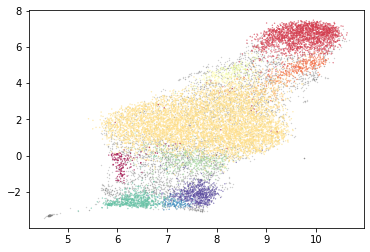

In [44]:
import matplotlib.pyplot as plt
clustered = (labels >= 0)

plt.scatter(standard_embedding[~clustered, 0],
            standard_embedding[~clustered, 1],
            c=(0.5, 0.5, 0.5),
            s=0.1,
            alpha=0.5)
plt.scatter(standard_embedding[clustered, 0],
            standard_embedding[clustered, 1],
            c=labels[clustered],
            s=0.1,
            cmap='Spectral');

**KMEANS + UMAP**

In [66]:
from sklearn.cluster import KMeans
clustering = KMeans(n_clusters=10, random_state=0).fit(z_images)

In [67]:
import umap

clusterable_embedding_K = umap.UMAP(
    n_neighbors=50,
    min_dist=0.0,
    n_components=2,
    random_state=0,
).fit_transform(z_images)

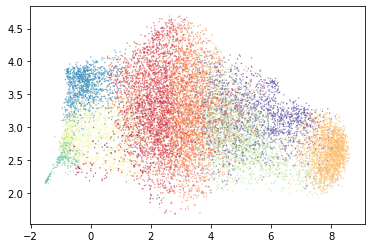

In [68]:
plt.scatter(clusterable_embedding_K[:, 0],
            clusterable_embedding_K[:, 1],
            c=clustering.labels_,
            s=0.1,
            cmap='Spectral');

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


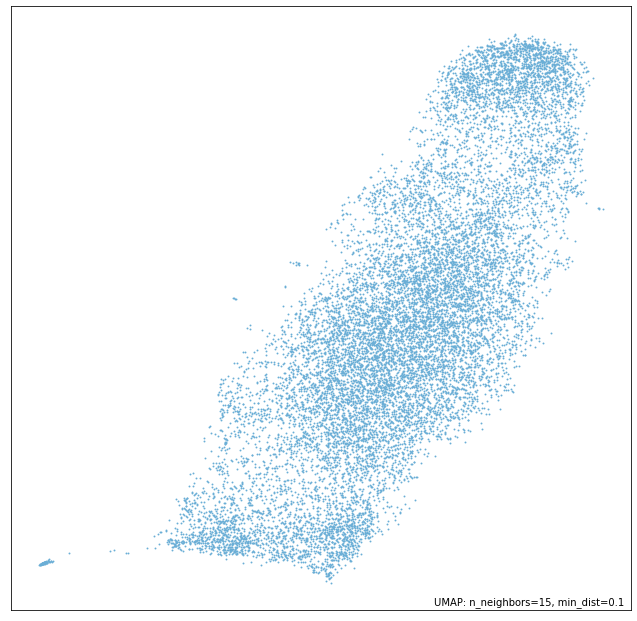

In [47]:
import umap
import umap.plot
mapper = umap.UMAP().fit(z_images)
umap.plot.points(mapper)

**INTERPOLATION EXPERIMENT**

In [ ]:
idx1 = 129
idx2 = 250
#requires batch_size 1!!!
def interpolate(idx1,idx2):
  make_dir()
  npoints = 30
  points = []
  gif_images = []
  with torch.no_grad():
      z1 = model_loaded.encode(train_loader.dataset[idx1].unsqueeze(0))[0].numpy()
      z2 = model_loaded.encode(train_loader.dataset[idx2].unsqueeze(0))[0].numpy()
      print(train_loader.dataset.__getname__(idx1))
      print(train_loader.dataset.__getname__(idx2))
    
      # Interpolation
      diff = z2-z1
      for i in range(0,npoints+1):
          point = z1 + i*diff/npoints
          points.append(point)
        
      # Plot each interpolated point
      for i,point in enumerate(points):
          image_tensor = model_loaded.decode(torch.from_numpy(point))
          gif_image = make_grid(image_tensor.cpu())
          gif_images.append(gif_image)
      image_to_vid(gif_images)

In [ ]:
interpolate(10, 120)


torch.Size([1, 3, 286, 286])
torch.Size([1, 3, 286, 286])
19752.png
20817.png


In [ ]:
w_out = ( - 1) * 2 - 2 * 0 + 1 * (10-1) + 0 + 1
print(w_out)

W_out=(W_in−1)×stride[1]−2×padding[1]+dilation[1]×(kernel_size[1]−1) +output_padding[1]+1 302 - 148 -